In [370]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pandas as pd
import os,sys,glob, h5py

from dlab import generalephys as ephys
from dlab.generalephys import placeAxesOnGrid, cleanAxes
from dlab import utils
from dlab import rf_analysis
from dlab import psth_and_raster as psth
from dlab import reliability_and_precision as rp
from dlab.continuous_traces import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import pearsonr, spearmanr, zscore
from itertools import combinations 

import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [785]:
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})   

imports

## load data

In [5]:
#load from raw data folders
# data_path = '/Volumes/s1/bioelectrics'
# dfs = [utils.df_from_phy(folder) for folder in glob.glob(data_path+'/*')]
# df = pd.concat(dfs,ignore_index=True)

#load from df from already loaded data
df = pd.read_json('/Users/danieljdenman/data/dailey_npix.json')

In [6]:
for e in df.mouse.unique():
    print('mouse: '+str(e)+'    # of units:'+str(df[df.mouse==e].shape[0]))

mouse: 3    # of units:58
mouse: 5    # of units:123
mouse: 6    # of units:162
mouse: 14    # of units:30
mouse: 15    # of units:142
mouse: 18    # of units:332
mouse: 7    # of units:128
mouse: 8    # of units:112
mouse: 9    # of units:52
mouse: 10    # of units:123
mouse: 20    # of units:246
mouse: 22    # of units:100


clean up some data formats from the saving

In [7]:
wave_ = []
for i,template in df.template.items():
    wave_.append(utils.get_peak_waveform_from_template(np.array(template)))
df.waveform=wave_

In [8]:
f_ = []
for i,times in df.times.items():
    try:
        rate = float(len(times)/(times[-1] - times[0]))
        if rate < 400:
            f_.append(rate)
        else:
            f_.append(0.)
    except:
        f_.append(0.)
df['overall_rate']=f_

typo in cohort name

In [ ]:
df.cohort[df.cohort=='NCPA']='NPCA'

per dailey:

In [16]:
df.cohort[df.mouse==9]='NPCD'
df.cohort[df.mouse==10]='NPCD'

In [19]:
df.to_json('/Users/danieljdenman/data/dailey_npix.json')

### classify fast-spiking and regular-spiking

No handles with labels found to put in legend.
No handles with labels found to put in legend.


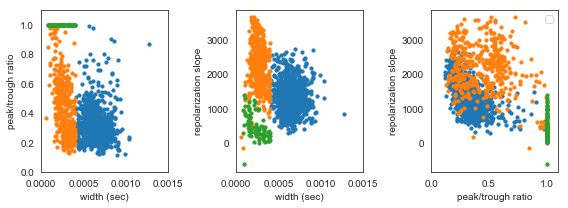

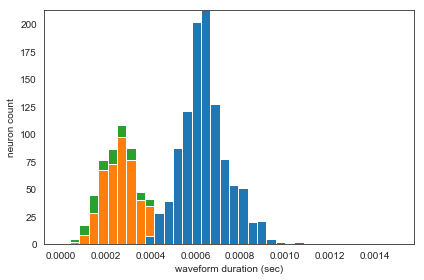

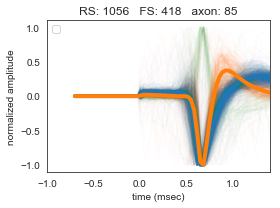

In [17]:
df = utils.classify_waveform_shape(df,plots=True,kmeans=0,
                                   basepath='/Users/administrator/Dropbox/cu/dailey_figs/')

### analyze some things

(0.1, 110)

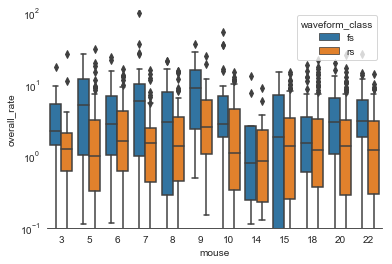

In [24]:
sns.boxplot(x="mouse", y="overall_rate", hue="waveform_class", 
                data=df[df.waveform_class!='up'][df.waveform_class!='axon'])
sns.despine(left=True)
plt.gca().set_yscale('log')
plt.gca().set_ylim(0.1,110)

(0.1, 110)

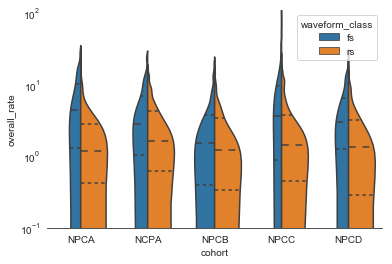

In [21]:
sns.violinplot(x="cohort", y="overall_rate", hue="waveform_class",
               split=True, inner="quart",
               data=df[df.waveform_class!='up'][df.waveform_class!='axon'])
sns.despine(left=True)
plt.gca().set_yscale('log')
plt.gca().set_ylim(0.1,110)

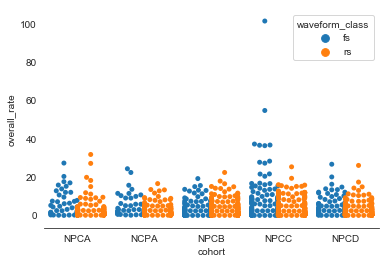

In [22]:
sns.swarmplot(x="cohort", y="overall_rate", hue="waveform_class",
               split=True, 
#                palette={"Yes": "y", "No": "b"},
                             data=df[df.waveform_class!='up'][df.waveform_class!='axon'])
sns.despine(left=True)

(0.1, 110)

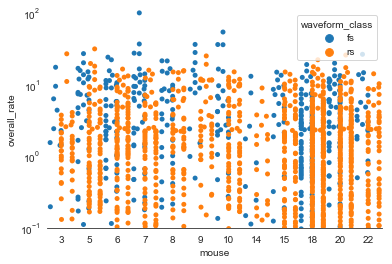

In [23]:
sns.swarmplot(x="mouse", y="overall_rate", hue="waveform_class",
               split=True, 
#                palette={"Yes": "y", "No": "b"},
                             data=df[df.waveform_class!='up'][df.waveform_class!='axon'])
sns.despine(left=True)
plt.gca().set_yscale('log')
plt.gca().set_ylim(0.1,110)

# comparing cohorts

In [66]:
sns.set_palette([sns.color_palette("BrBG", 7)[0],
                 sns.color_palette("BrBG", 7)[-1],
                 sns.color_palette("BrBG", 7)[1],
                 sns.color_palette("BrBG", 7)[-2],])

(0.1, 40)

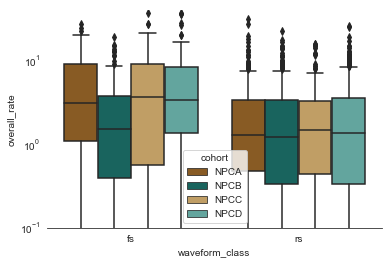

In [67]:
sns.boxplot(x="waveform_class", y="overall_rate", hue='cohort',
                data=df[df.waveform_class!='axon'][df.waveform_class!='up'])
sns.despine(left=True)
plt.gca().set_yscale('log')
plt.gca().set_ylim(0.1,40)

## waveforms
#### overlaid waveforms between the cohorts

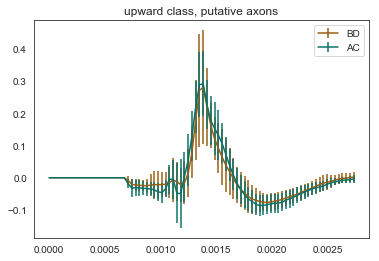

In [110]:
waveforms_1 = df.template[df.waveform_class=='up'][df.cohort!='NPCA'][df.cohort!='NPCC']
waveforms_2 = df.template[df.waveform_class=='up'][df.cohort!='NPCB'][df.cohort!='NPCD']
waveform_1 = np.zeros((82,waveforms_1.shape[0]))
waveform_2 = np.zeros((82,waveforms_2.shape[0]))
for i,t in enumerate(waveforms_1):
    waveform_1[:,i]= utils.get_peak_waveform_from_template(np.array(t))
for i,t in enumerate(waveforms_2):
    waveform_2[:,i] = utils.get_peak_waveform_from_template(np.array(t))
plt.errorbar(np.linspace(0,82./30000.,82),np.nanmean(waveform_1,axis=1),yerr=np.std(waveform_1,axis=1),label='BD')
plt.errorbar(np.linspace(0,82./30000.,82),np.nanmean(waveform_2,axis=1),yerr=np.std(waveform_2,axis=1),label='AC')
plt.legend()
d=plt.title('upward class, putative axons')

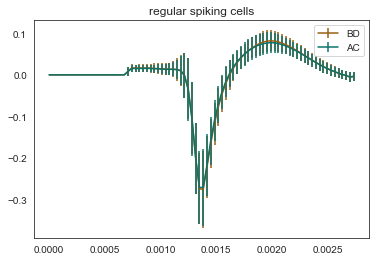

In [111]:
waveforms_1 = df.template[df.waveform_class=='rs'][df.cohort!='NPCA'][df.cohort!='NPCC']
waveforms_2 = df.template[df.waveform_class=='rs'][df.cohort!='NPCB'][df.cohort!='NPCD']
waveform_1 = np.zeros((82,waveforms_1.shape[0]))
waveform_2 = np.zeros((82,waveforms_2.shape[0]))
for i,t in enumerate(waveforms_1):
    waveform_1[:,i]= utils.get_peak_waveform_from_template(np.array(t))
for i,t in enumerate(waveforms_2):
    waveform_2[:,i] = utils.get_peak_waveform_from_template(np.array(t))
plt.errorbar(np.linspace(0,82./30000.,82),np.nanmean(waveform_1,axis=1),yerr=np.std(waveform_1,axis=1),label='BD')
plt.errorbar(np.linspace(0,82./30000.,82),np.nanmean(waveform_2,axis=1),yerr=np.std(waveform_2,axis=1),label='AC')
plt.legend()
d=plt.title('regular spiking cells')

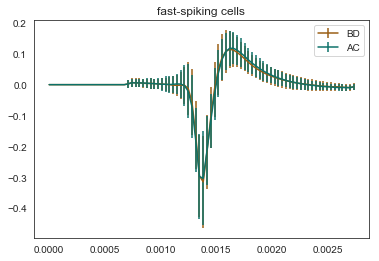

In [112]:
waveforms_1 = df.template[df.waveform_class=='fs'][df.cohort!='NPCA'][df.cohort!='NPCC']
waveforms_2 = df.template[df.waveform_class=='fs'][df.cohort!='NPCB'][df.cohort!='NPCD']
waveform_1 = np.zeros((82,waveforms_1.shape[0]))
waveform_2 = np.zeros((82,waveforms_2.shape[0]))
for i,t in enumerate(waveforms_1):
    waveform_1[:,i]= utils.get_peak_waveform_from_template(np.array(t))
for i,t in enumerate(waveforms_2):
    waveform_2[:,i] = utils.get_peak_waveform_from_template(np.array(t))
plt.errorbar(np.linspace(0,82./30000.,82),np.nanmean(waveform_1,axis=1),yerr=np.std(waveform_1,axis=1),label='BD')
plt.errorbar(np.linspace(0,82./30000.,82),np.nanmean(waveform_2,axis=1),yerr=np.std(waveform_2,axis=1),label='AC')
plt.legend()
d=plt.title('fast-spiking cells')

## by depth
first find position on probe

In [44]:
xpos,ypos = [],[]
for ind in df.index:
    mean_template = np.array(df.template[ind])
    site_positions = ephys.option234_positions[:mean_template.T.shape[0]]  
    weights = np.zeros(site_positions.shape)
    for channel in range(site_positions.shape[0]):
        weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
    weights = weights/np.max(weights)
    low_values_indices = weights < 0.25  # Where values are low,
    weights[low_values_indices] = 0      # make the weight 0
    (xpos_,ypos_)=np.average(site_positions,axis=0,weights=weights)
    xpos.extend([xpos_])
    ypos.extend([np.abs(ypos_-3840)])
    
df['xpos']=xpos
df['ypos']=ypos

Text(0.5, 0, 'position on probe, 0 is at the tip, in um')

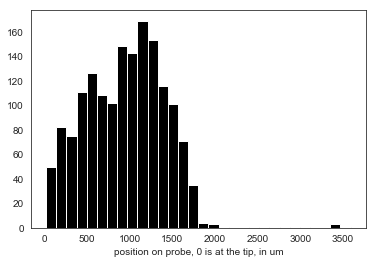

In [119]:
d=plt.hist(df.ypos,bins=30,color='k')
plt.xlabel('position on probe, 0 is at the tip, in um')

adjust for the depth, as measured from the data (dailey might just have this written down somewhere...)

In [142]:
offsets = np.zeros(df.shape[0])
df['offset']=offsets
for mouse in df.mouse.unique():
#     plt.figure()
#     plt.plot(df[df.mouse==mouse].ypos)
    end = np.where(np.abs(np.diff(df[df.mouse==mouse].ypos)) > 500)
#     plt.gca().axhline(np.array(df[df.mouse==mouse].ypos)[end[0][0]-1])
    if np.max(df[df.mouse==mouse].ypos) < 2000:
        offset = np.max(df[df.mouse==mouse].ypos)
    else: 
        if np.array(df[df.mouse==mouse].ypos)[end[0][0]-1] < 2000:
            offset = np.array(df[df.mouse==mouse].ypos)[end[0][0]-1]
        else:
            if np.array(df[df.mouse==mouse].ypos)[end[0][0]-2] < 2000:
                offset = np.array(df[df.mouse==mouse].ypos)[end[0][0]-2]
    df.offset[df.mouse==mouse] = offset    
        
    

Text(0.5, 0, 'depth from highest unitm, um')

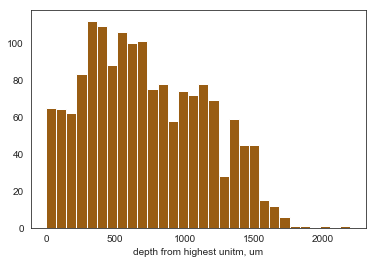

In [148]:
df['depth']=np.abs(df.ypos-df.offset)
d=plt.hist(df.depth,bins=30)
plt.xlabel('depth from highest unitm, um')

(2000, 0)

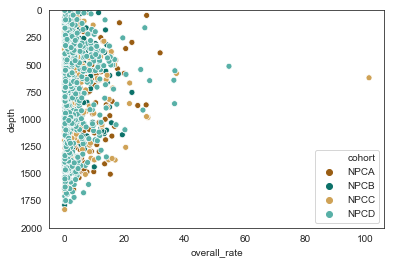

In [151]:
sns.scatterplot(x='overall_rate',y='depth',data=df,hue='cohort')
plt.ylim(2000,0)

# Population Analyses


## noise correlation
how do we define the epochs to measure this under?
spomnt (random times)
peridos of a bunch of activity (presumable trials, from threholds or patterns in the poplation rate)

In [342]:
df['random_count']=[np.zeros((np.shape(df)[0],1)) for i in range(df.shape[0])]
# df['events_count']=[np.zeros((np.shape(df)[0],1)) for i in range(df.shape[0])]

mouse 3 done.
mouse 5 done.
mouse 6 done.
mouse 14 done.
mouse 15 done.
mouse 18 done.
mouse 8 done.


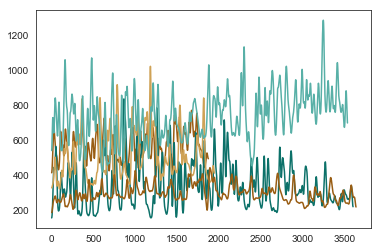

In [315]:
for mouseid in df.mouse.unique():
    df_ = df[df.mouse==mouseid]
    if sum(df_['events_count'][df_.index[0]]) == 0.0:
        start_=100;end_ = 0
        mega_train = []
        for t in df_.times:
            if np.min(np.array(t)) < start_: start_ = np.min(np.array(t))
            if np.min(np.array(t)) > end_: end_ = np.max(np.array(t)) 
            mega_train.extend(t)
        bins = np.linspace(start_,end_,(end_-start_))
        mega_count = np.zeros(np.shape(bins))
        for i,b in enumerate(bins[1:]):
            mega_count[i]=np.shape(np.where((mega_train > bins[i-1]) & (mega_train < bins[i]))[0])[0]
        smoothed = gaussian_filter1d(mega_count,8)
        plt.plot(smoothed)
        p=find_peaks(smoothed)[0]
        if np.shape(p)[0] > 100:
            p = np.random.choice(p,100,replace=False)
        for i in df_.index:
            t=np.array(df_.times[i])
            try:
                resp_1 = rp.get_binarized(t,p,.250)
                df['events_count'][i] = np.sum(resp_1,axis=1)
            except:
                print(i)
                df['events_count'][i] = [np.nan]
    else: print('mouse '+str(mouseid)+' done.')

In [422]:
for mouseid in df.mouse.unique():
    df_ = df[df.mouse==mouseid]
    start_=1000;end_ = -1
    for t in df_.times:
        if np.min(np.array(t)) < start_: start_ = np.min(np.array(t))
        if np.min(np.array(t)) > end_: end_ = np.max(np.array(t)) 
    random_times = np.random.uniform(start_,end_,200)[50:150]
    
    for i in df_.index:
        try:
            t=np.array(df.times[i])
            resp_1 = rp.get_binned(t,random_times,0.1,post=0.5)
            count = np.sum(resp_1,axis=1)
            if np.shape(count)[0]==100:
                df['random_count'][i] = count
            else:
                print('wtf: '+str(i)+' '+str(np.shape(resp_1)))
                df['random_count'][i] = np.repeat(np.nan,100)
        except:
            print(i)
            df['random_count'][i] = np.repeat(np.nan,100)

In [463]:
random_Rsc = {}
events_Rsc = {}
for mouseid in df.mouse.unique():
    random_Rsc[mouseid] = pairwise_correlation(df[df.mouse==mouseid],'random_count')
    events_Rsc[mouseid] = pairwise_correlation(df[df.mouse==mouseid],'events_count')


In [490]:
total_pairs=0
for mouseid in df.mouse.unique():
    total_pairs += int(df[df.mouse==mouseid].shape[0]*(df[df.mouse==mouseid].shape[0]-1)/2)

In [560]:
df_pairs = pd.DataFrame(index=range(total_pairs),
                        columns=['mouse','ind1','ind2','cell1','cell2','type1','type2','cohort',
                                 'r_spont','r_event'])

In [584]:
start_ = 0
for mouseid in df.mouse.unique():
    df_=df[df.mouse==mouseid]
    numpairs=len(list(combinations(df_.cell,2)))
    
    df_pairs['mouse'][start_:start_+numpairs]=mouseid
    df_pairs['cell1'][start_:start_+numpairs]=[c[0] for c in list(combinations(df_.cell,2))]
    df_pairs['cell2'][start_:start_+numpairs]=[c[1] for c in list(combinations(df_.cell,2))]
    df_pairs['ind1'][start_:start_+numpairs]=[c[0] for c in list(combinations(df_.index,2))]
    df_pairs['ind2'][start_:start_+numpairs]=[c[1] for c in list(combinations(df_.index,2))]
    df_pairs['type1'][start_:start_+numpairs]=[c[0] for c in list(combinations(df_.waveform_class,2))]
    df_pairs['type2'][start_:start_+numpairs]=[c[1] for c in list(combinations(df_.waveform_class,2))]
    df_pairs['cohort'][start_:start_+numpairs]=df_.cohort.unique()[0]
    df_pairs['r_spont'][start_:start_+numpairs]=[float(random_Rsc[mouseid][i]) for i in list(combinations(range(df_.shape[0]),2))]
    df_pairs['r_event'][start_:start_+numpairs]=[float(events_Rsc[mouseid][i]) for i in list(combinations(range(df_.shape[0]),2))]
    
    start_+=numpairs
    

In [589]:
df_pairs.to_json('/Users/danieljdenman/data/dailey_npix_pairs.json')

In [590]:
df_pairs_ = pd.read_json('/Users/danieljdenman/data/dailey_npix_pairs.json')

(-0.8, 0.8)

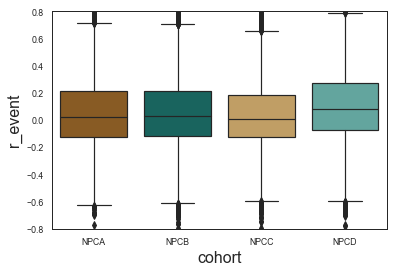

In [797]:
sns.boxplot(x="cohort", y="r_event",
            data=df_pairs_)
# plt.gca().set_yscale('log')
plt.gca().set_ylim(-0.8,0.8)

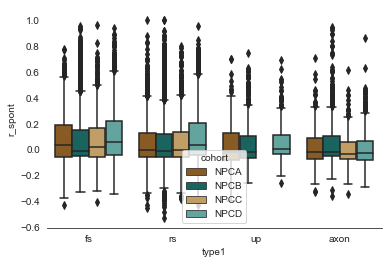

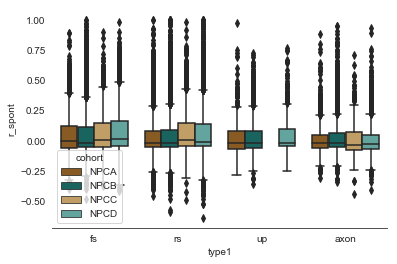

In [600]:
sns.boxplot(x="type1", y="r_spont",hue='cohort',
            data=df_pairs_[df_pairs_.type2=='fs'])#[df_pairs.type2!='fs'][df_pairs.type2!='axon'][df_pairs.type2!='up'])
sns.despine(left=True)
# plt.gca().set_yscale('log')
plt.figure()
sns.boxplot(x="type1", y="r_spont",hue='cohort',
            data=df_pairs_[df_pairs_.type2=='rs'])#[df_pairs.type2!='fs'][df_pairs.type2!='axon'][df_pairs.type2!='up'])
sns.despine(left=True)

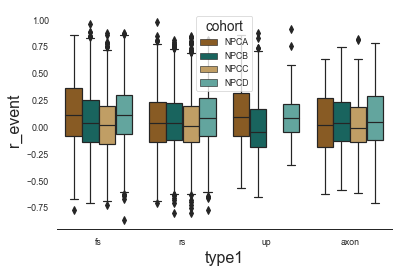

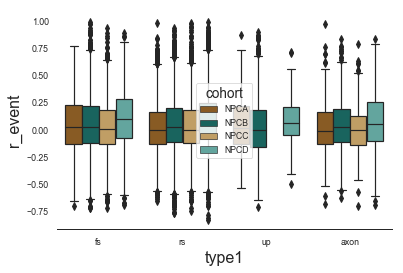

In [786]:
sns.boxplot(x="type1", y="r_event",hue='cohort',
            data=df_pairs_[df_pairs_.type2=='fs'])#[df_pairs.type2!='fs'][df_pairs.type2!='axon'][df_pairs.type2!='up'])
sns.despine(left=True)
# plt.gca().set_yscale('log')
plt.figure()
sns.boxplot(x="type1", y="r_event",hue='cohort',
            data=df_pairs_[df_pairs_.type2=='rs'])#[df_pairs.type2!='fs'][df_pairs.type2!='axon'][df_pairs.type2!='up'])
sns.despine(left=True)

## jitter, population
not sure what to align this too, without reaches.<br>
perhaps we can use overall dispersion? ISI of the mega_train?

## dimensionality
- cunningham and yu, 2014
- fusi 2016
- semedo kohn 2019
- stringer et al 2019

In [604]:
from sklearn import decomposition, datasets

In [707]:
df_mouse = df_pairs = pd.DataFrame(index=range(df.mouse.unique().shape[0]),
                        columns=['mouse','cohort'])

make a tensor
<br>should be rows = time, columns = neuron, content = count

In [776]:
def make_tensor(df,time,duration,binsize):
    #mak
    cell_ = rp.get_binned(df.times[df.index[0]],[time],pre=0.,post=duration,binsize=binsize)
    tensor = np.zeros((len(cell_[0]),df.shape[0]))
    ind=0
    for t in df.times:
        cell_ = rp.get_binned(t,[time],pre=0.,post=duration,binsize=binsize)
        tensor[:,ind] = cell_[0]
        ind+=1
    return tensor

def make_tensor_(df,times,duration,binsize):
    #mak
    cell_ = rp.get_binned(df.times[df.index[0]],[times[0]],pre=0.,post=duration,binsize=binsize)
    tensor = np.zeros((len(cell_[0]),df.shape[0]))
    ind=0
    for t in df.times:
        cell_ = rp.get_binned(t,times,pre=0.,post=duration,binsize=binsize)
        tensor[:,ind] = np.mean(np.array(cell_),axis=0)
        ind+=1
    return tensor

In [713]:
ten = 

find dimensionality:
>we found the number of dimensions mpeak that maximized the
cross-validated log-likelihood of the observed residuals; (2) we fitted a FA model with mpeak dimensions and chose m, using the
eigenvalue decomposition, as the smallest dimensionality that captured 95% of the variance in the shared covariance matrix LLT> - Semedo and Kohn, 2019

In [716]:
def dimensionality_PCA(ten):
    ev=[]
    for i in range(min(ten.shape[0], ten.shape[1])-1):
        PCA = decomposition.PCA(n_components=i)
        f=PCA.fit(ten)
        ev.append(sum(PCA.explained_variance_))
    return np.where(ev>np.max(ev)*.95)[0][0]

In [782]:
dims = []
# mouse_ = []
# cohort_ = []
for mouse in df.mouse.unique():
    df_=df[df.mouse==mouse]
    ten = make_tensor(df_,80.,10,.05).T
    dims.append(dimensionality_PCA(ten))
#     mouse_.append(mouse)
#     cohort_.append(df_.cohort.unique()[0])
# df_mouse['mouse']=mouse_
# df_mouse['cohort']=cohort_
df_mouse['dimensionality_random']=dims

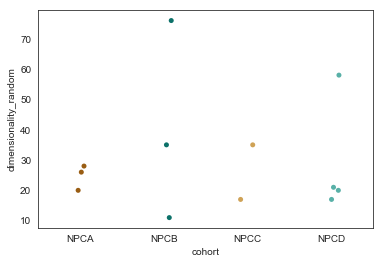

In [783]:
sns.stripplot(data=df_mouse,x='cohort',y='dimensionality_random')
# plt.ylim(0,0.8)

In [771]:
dims = []
for mouse in df.mouse.unique():

    df_=df[df.mouse==mouse]
    if sum(df_['events_count'][df_.index[0]]) == 0.0:
        start_=100;end_ = 0
        mega_train = []
        for t in df_.times:
            if np.min(np.array(t)) < start_: start_ = np.min(np.array(t))
            if np.min(np.array(t)) > end_: end_ = np.max(np.array(t)) 
            mega_train.extend(t)
        bins = np.linspace(start_,end_,(end_-start_))
        mega_count = np.zeros(np.shape(bins))
        for i,b in enumerate(bins[1:]):
            mega_count[i]=np.shape(np.where((mega_train > bins[i-1]) & (mega_train < bins[i]))[0])[0]
        smoothed = gaussian_filter1d(mega_count,8)
        p=np.linspace(start_,end_,(end_-start_))[find_peaks(smoothed)[0]]
        if np.shape(p)[0] > 100:
            p = np.random.choice(p,100,replace=False)
            

    ten = make_tensor(df_,np.random.choice(p,1,replace=False)[0],10,.05).T
    dims.append(dimensionality_PCA(ten))

df_mouse['dimensionality_event']=dims

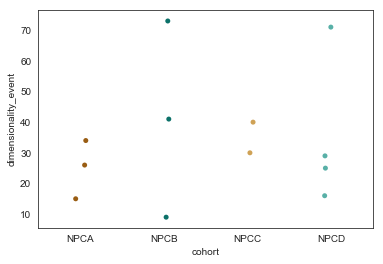

In [772]:
sns.stripplot(data=df_mouse,x='cohort',y='dimensionality_event')

In [787]:
dims = []
megatrains = []
for mouse in df.mouse.unique():

    df_=df[df.mouse==mouse]
    if sum(df_['events_count'][df_.index[0]]) == 0.0:
        start_=100;end_ = 0
        mega_train = []
        for t in df_.times:
            if np.min(np.array(t)) < start_: start_ = np.min(np.array(t))
            if np.min(np.array(t)) > end_: end_ = np.max(np.array(t)) 
            mega_train.extend(t)
        megatrains.append(mega_train)
        bins = np.linspace(start_,end_,(end_-start_))
        mega_count = np.zeros(np.shape(bins))
        for i,b in enumerate(bins[1:]):
            mega_count[i]=np.shape(np.where((mega_train > bins[i-1]) & (mega_train < bins[i]))[0])[0]
        smoothed = gaussian_filter1d(mega_count,8)
        p=np.linspace(start_,end_,(end_-start_))[find_peaks(smoothed)[0]]
        if np.shape(p)[0] > 100:
            p = np.random.choice(p,100,replace=False)
            

    ten = make_tensor_(df_,p,3,.1).T
    dims.append(dimensionality_PCA(ten))

df_mouse['dimensionality_events']=dims

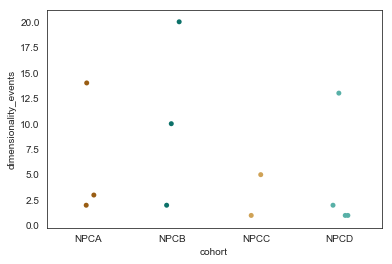

In [778]:
sns.stripplot(data=df_mouse,x='cohort',y='dimensionality_events')

## stability of reach trajectories
mean distance between trajectories, trial to trial
again, need trials for these

## criticality

## avalanches
durstewitz 2017

## network of synchrony
graphs of cells that are synchronous
proportion of cells that are synchrounous

# 2020 04 03 zoom meeting

Thoughts for grant:
Taking analysis of effects of demylenation on motor cortex activity (which showed interesting things at the cell-by-cell level) to the population level. 
<br>Aims: 
- 1. How does demyelination affect popuation activity?
    - demyelination reduces precision? (need pops to measure, per my current bioRxiv/Nature Comms)
    - demyelination changes structure of correlated variability?
    - how does demyelination affect neural population trajectories?
        - demyelination changes dimensionality of activity (increase? decrease? both are plausible)
        - demyelnation changes size of attractor in neural space (less stable, less critical)
        - probablity of avalanches (cascades of activity)
        
- 2. How/does(?) remyelination/treatment rescue popuation activity?
    - see above, during remyelination/treatment phase
    
--> inerlaminar ineractions are a potential layer to add. how does the L2/3-->L5 interaction change?

let cristin know what can be useful of previous data.
- lfps, probably. i'm thinking showing a difference in magnitude of any peak, or even a difference in frequency of a known peak, would be an argument for a disruption (or enhancement??) of population activity in demyelination. 

timeline:
    - is june doable for an R01? no, but R21 probably do able.
    - --> todo: propose some population analyses. also, maybe do some. 